In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from astropy.nddata import CCDData
from ccdproc import trim_image
from astropy import units as u

from specutils import Spectrum1D
from astropy.nddata import StdDevUncertainty

# need to get import to work in notebook w/o global package install
import sys  
sys.path.append('..')

from apextract import trace, extract
from fluxcal import standard_sensfunc, apply_sensfunc, onedstd, obs_extinction, airmass_cor

In [2]:
fcal = '../../pydis_example/apo05/05may31.0020r.fits' # Flux std star observation

img = CCDData.read(fcal, unit=u.adu)
# put in units of ADU/s
img.data = img.data / (img.header['EXPTIME'])
img.unit = u.adu / u.s

# trim off bias section
img = trim_image(img, fits_section=img.header['DATASEC'])


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


In [3]:
# Trace & Extract the standard star spectrum. See the extract example demo for more details
tr = trace(img, display=False, nbins=25)

ex_tbl = extract(img, tr, display=False, apwidth=8, skysep=3, skywidth=7)

<ErrorbarContainer object of 3 artists>

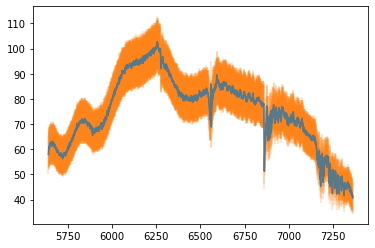

In [4]:
# this data comes from the APO DIS red channel, which has wavelength axis backwards
# (despite not mentioning in the header)
wapprox = (np.arange(img.shape[1]) - img.shape[1]/2)[::-1] * img.header['DISPDW'] + img.header['DISPWC']

wapprox = wapprox * u.angstrom

# obj_flux = (flux_std - sky_std) * u.adu / u.s
obj_flux = ex_tbl['flux'] - ex_tbl['skyflux']

plt.plot(wapprox, obj_flux)
plt.errorbar(wapprox.value, obj_flux.data, yerr=ex_tbl['fluxerr'].data, alpha=0.25)

In [5]:
stdstar=onedstd('spec50cal/bd284211.dat')

stdstar

wave,mag,width,flux
Angstrom,mag,Angstrom,erg / (Angstrom cm2 s)
float64,float64,float64,float64
3200.0,9.63,50.0,1.494585437147621e-12
3250.0,9.58,50.0,1.517238942133151e-12
3300.0,9.56,50.0,1.498969593050037e-12
3350.0,9.57,50.0,1.4412226833675205e-12
3400.0,9.6,50.0,1.3610148657873372e-12
3450.0,9.64,50.0,1.2740383847001297e-12
3500.0,9.67,50.0,1.2041611578377217e-12
3550.0,9.68,50.0,1.159748973561773e-12


In [20]:
obj_flux = ex_tbl['flux'] - ex_tbl['skyflux']


obj_spectrum = Spectrum1D(spectral_axis=wapprox, flux=obj_flux.quantity, 
                          uncertainty=StdDevUncertainty(ex_tbl['fluxerr']))

In [19]:
stdstar['flux'].unit / obj_spectrum.flux.unit

Unit("erg / (adu Angstrom cm2)")

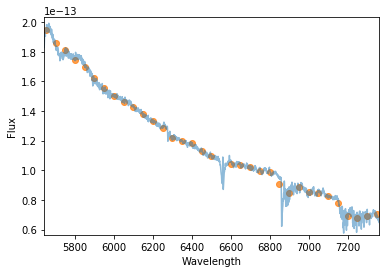

In [22]:
sensfunc_lin = standard_sensfunc(obj_spectrum, stdstar, display=True, mode='linear')

In [23]:
sensfunc_lin

wave,S
Angstrom,erg / (adu Angstrom cm2)
float64,float64
7361.32,1.594003832832395e-15
7360.48,1.594003832832395e-15
7359.64,1.594003832832395e-15
7358.8,1.594003832832395e-15
7357.96,1.594003832832395e-15
7357.12,1.594003832832395e-15
7356.28,1.594003832832395e-15
7355.44,1.594003832832395e-15


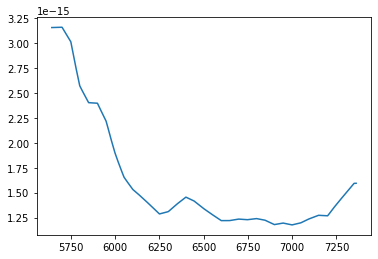

In [24]:
# the actual sensitivity function(s), which in theory include some crude information about 
# the flat fielding (response) - though the reference spectrum is very coarse.
plt.plot(sensfunc_lin['wave'], sensfunc_lin['S'])

(0, 3e-13)

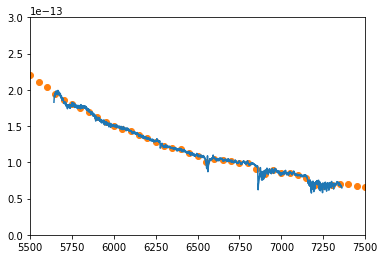

In [25]:
# now apply the sensfunc back to the std star to demonstrate
# NOTE: this only works b/c wavelength is exactly the same. Normally use `apply_sensfunc`
plt.plot(wapprox, obj_flux * sensfunc_lin['S'])
plt.scatter(stdstar['wave'], stdstar['flux'], c='C1')
plt.xlim(5500,7500)
plt.ylim(0, 0.3e-12)

In [27]:
# now let's demo the Airmass correction
Xfile = obs_extinction('apoextinct.dat')

In [28]:
AIRVAL = 1.2 # some made up airmass

Atest = airmass_cor(obj_spectrum, AIRVAL, Xfile)

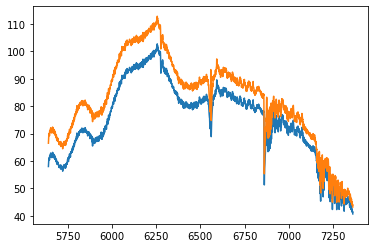

In [29]:
plt.plot(obj_spectrum.wavelength, obj_spectrum.flux)
plt.plot(Atest.wavelength, Atest.flux)

In [30]:
# Now demo how to apply a sensfuc to a new spectrum (just happens to be the same spectrum here...)
Stest = apply_sensfunc(obj_spectrum, sensfunc_lin)

In [31]:
Stest

<Spectrum1D(flux=<Quantity [6.48133344e-14, 6.61846837e-14, 6.55919926e-14, ...,
           1.89416152e-13, 1.87163672e-13, 1.82889093e-13] erg / (Angstrom cm2 s)>, spectral_axis=<Quantity [7361.32, 7360.48, 7359.64, ..., 5643.52, 5642.68, 5641.84] Angstrom>, uncertainty=StdDevUncertainty([1.01658540e-14, 1.02734795e-14, 1.02269623e-14, ...,
                   2.44516708e-14, 2.43076322e-14, 2.40254241e-14]))>

(0, 3e-13)

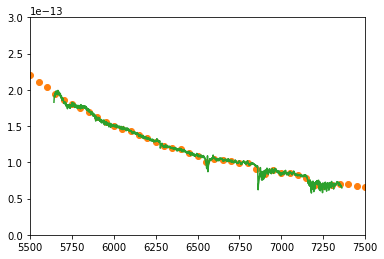

In [32]:
plt.scatter(stdstar['wave'], stdstar['flux'], c='C1')

plt.plot(Stest.wavelength, Stest.flux, c='C2')
plt.xlim(5500,7500)
plt.ylim(0, 0.3e-12)